In [32]:
import pandas as pd
import geopandas as gpd
from dask.distributed import Client
import dask.dataframe as dd
from dask_jobqueue import SLURMCluster
import os
import matplotlib.pyplot as plt
import constants
import numpy as np
from panel_utilities import get_value_variable_names
import dask_geopandas
INPUT_DATA_EVICTIONS = "../data/02_intermediate/evictions.csv"
INPUT_DATA_TRACTS = "../data/02_intermediate/tracts.csv"
INPUT_DATA_TAX_PARCELS = "../data/02_intermediate/tax_parcels.gpkg"
INPUT_DATA_ZESTIMATES = "../data/02_intermediate/zestimates.csv"
INPUT_DATA_CRIME = "../data/01_raw/crime_incidents"
INPUT_DATA_NEIGHBORHOODS = "../data/01_raw/Boston_Neighborhoods/Boston_Neighborhoods.shp"
OUTPUT_DATA_ZILLOW = "../data/03_cleaned/zestimates_analysis.csv"
OUTPUT_DATA_CRIME = "../data/03_cleaned/crime_analysis_monthly.csv"
OUTPUT_DATA_CRIME_FULL_SAMPLE = "../data/03_cleaned/crime_analysis_monthly_full_sample.csv"
OUTPUT_DATA_NEIGHBORHOOD_CRIME_COUNTS = "../data/03_cleaned/neighborhood_crime_counts.csv"
OUTPUT_TABLES = "../output/final_paper/tables/"
VERBOSE = True
N_PARTITIONS = 1
value_vars_to_concat = []  # A list of DataFrames, where each DataFrame contains the panel data for a single outcome variable and has case_number as its index.

In [33]:
client = Client()

/Users/ashanmu1/Documents/GitHub/seniorthesis/venv/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59820 instead
  warnings.warn(


In [35]:
# Read crime data as Dask DataFrame, then compute back to DataFrame.
crime_df = (dd.read_csv(INPUT_DATA_CRIME + "/*.csv", dtype={'REPORTING_AREA': 'object', 'SHOOTING': 'object'})
                .dropna(subset=['Long', 'Lat', 'OCCURRED_ON_DATE'])  # Drop crimes missing latitude, longitude, or date, as they cannot be merged with panel.
                .rename(columns={'OCCURRED_ON_DATE': 'month_of_crime_incident'})
                .drop(columns=['OFFENSE_CODE_GROUP', 'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'YEAR', 'MONTH',
                               'DAY_OF_WEEK', 'HOUR', 'UCR_PART', 'STREET', 'Location'])  # Drop unneeded columns
                .compute())
                # Must call compute here and then briefly convert back to in-memory dataset because dask_geopandas.points_from_xy not working.
crime_df.loc[:, 'INCIDENT_NUMBER'] = 1  # Replace column with 1s so we can count crimes using sum function.
# Keep track of the month of crime incident in YYYY-MM format.
crime_df.loc[:, 'month_of_crime_incident'] = pd.to_datetime(crime_df['month_of_crime_incident'].str[:10]).dt.to_period("M").astype(str)

/Users/ashanmu1/Documents/GitHub/seniorthesis/venv/lib/python3.10/site-packages/dask/dataframe/io/csv.py:194: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/ashanmu1/Documents/GitHub/seniorthesis/venv/lib/python3.10/site-packages/dask/dataframe/io/csv.py:194: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/ashanmu1/Documents/GitHub/seniorthesis/venv/lib/python3.10/site-packages/dask/dataframe/io/csv.py:194: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/ashanmu1/Documents/GitHub/seniorthesis/venv/lib/python3.10/site-packages/dask/dataframe/io/csv.py:194: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/Users/ashanmu1/Documents/GitHub/seniorthesi

<AxesSubplot: xlabel='month_of_crime_incident'>

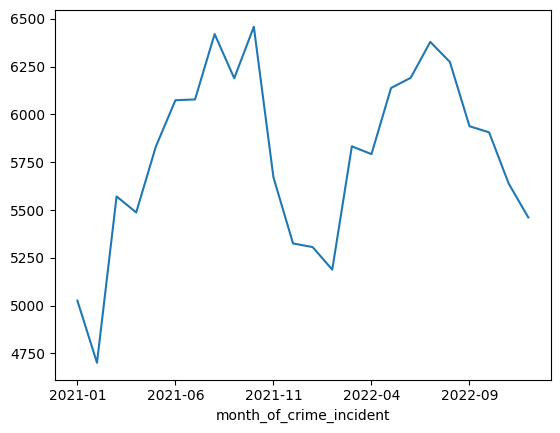

In [42]:
crime_df.groupby('month_of_crime_incident').count()['INCIDENT_NUMBER'].loc['2021-01':'2022-12'].plot()

In [43]:
# todo:
1. plot crime series and eviction series on same graph 
2. vertical lines on beginning and end dates of boston eviction moratorium: 2021-09 to 2022-03
3. check things out 

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (2146310902.py, line 3)

<AxesSubplot: xlabel='month_of_crime_incident'>

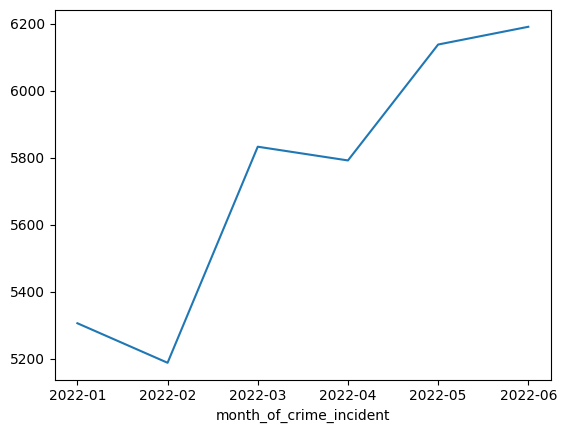

In [69]:
fig, ax1 = plt.subplots(1, 1, sharex=True)
crime_df.groupby('month_of_crime_incident').count()['INCIDENT_NUMBER'].loc['2022-01':'2022-06'].plot(ax=ax1)


In [71]:
evictions_df = pd.read_csv(OUTPUT_DATA_CRIME_FULL_SAMPLE)

file_month
2019-04     32
2019-05    355
2019-06    385
2019-07    526
2019-08    438
2019-09    468
2019-10    459
2019-11    441
2019-12    476
2020-01    486
2020-02    472
2020-03    388
2020-04     54
2020-05      5
2020-06      6
2020-07      9
2020-08     10
2020-09      5
2020-10     29
2020-11    226
2020-12    313
2021-01    213
2021-02    190
2021-03    344
2021-04    197
2021-05    154
2021-06    153
2021-07    143
2021-08    177
2021-09    162
2021-10    154
2021-11    170
2021-12    201
Name: case_number, dtype: int64

In [73]:
evictions_df.groupby('file_month').count()['case_number']

file_month
2019-04     32
2019-05    355
2019-06    385
2019-07    526
2019-08    438
2019-09    468
2019-10    459
2019-11    441
2019-12    476
2020-01    486
2020-02    472
2020-03    388
2020-04     54
2020-05      5
2020-06      6
2020-07      9
2020-08     10
2020-09      5
2020-10     29
2020-11    226
2020-12    313
2021-01    213
2021-02    190
2021-03    344
2021-04    197
2021-05    154
2021-06    153
2021-07    143
2021-08    177
2021-09    162
2021-10    154
2021-11    170
2021-12    201
Name: case_number, dtype: int64

2024-03-14 20:34:05,058 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 18 memory: 96 MB fds: 442>>
Traceback (most recent call last):
  File "/Users/ashanmu1/Documents/GitHub/seniorthesis/venv/lib/python3.10/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/Users/ashanmu1/Documents/GitHub/seniorthesis/venv/lib/python3.10/site-packages/distributed/system_monitor.py", line 134, in update
    net_ioc = psutil.net_io_counters()
  File "/Users/ashanmu1/Documents/GitHub/seniorthesis/venv/lib/python3.10/site-packages/psutil/__init__.py", line 2114, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory
ERROR:tornado.application:Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 18 memory: 96 MB fds: 442>>
Traceback (most recent call last):
  File "/Users/ashanmu1/Documents/GitHub/seniorthesis/venv/lib/python3.10